In [1]:
%load_ext autoreload
%autoreload 2

import os
import itertools
import utils
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt

from matplotlib import cm

In [2]:
from utils import plot_domain, plot_measure, send_zero_transparent

from fastsweeper.sweep import fast_sweep

from utils.rooms import room2

In [3]:
print(os.getcwd())

/home/manifold/Documents/pyprojects/mva-optimaltransport/project


In [4]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 90

# More marginals

## Setup

In [5]:
from typing import List

In [6]:
IMAGE_DIR = "images/"
os.makedirs(IMAGE_DIR, exist_ok=True)

In [8]:
nx = 181
xar = np.linspace(0, 1, nx)
xg, yg = np.meshgrid(xar, xar)

extent = [0, xar.max(), 0, 1]

In [18]:
# Obstacle domain
mask = room2(nx, xg, yg)

obstacle_idx = np.argwhere(mask)

domain_img = np.zeros((nx, nx, 4))
domain_img[mask, 3] = 1.

# Exit (target)
exit_mask = (np.abs(xg - .86) <= 0.08) & (np.abs(yg - .12) <= 0.08)
## Layer for plotting
exit_layer = np.zeros((nx, nx, 4))
exit_layer[exit_mask, 0] = 1.
exit_layer[exit_mask, 3] = 1.

In [19]:
rho_0 = (np.abs(xg - 0.5) <= 0.14) & (np.abs(yg - 0.82) <= 0.14)
rho_0 = rho_0.astype(np.float64)
rho_0 /= rho_0.sum()  # normalize the density

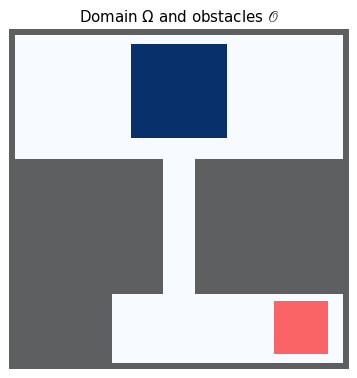

In [20]:
fig = plt.figure()
plot_domain(domain_img)
plot_measure(rho_0)
plot_domain(exit_layer, alpha=.6)
plt.title("Domain $\\Omega$ and obstacles $\\mathscr{O}$")
plt.axis('off');

In [21]:
# Use a HJ potential
# Initialize the new distance array
potential_new_ = np.empty((nx, nx))
speed_field = np.ones_like(potential_new_)
speed_field[mask] = 1e3  # "Kill" walking through the obstacles
dx = xar[1] - xar[0]
sweep_iters = 150

fast_sweep(speed_field, dx, exit_mask, sweep_iters, potential_new_,
           init_value=6.)
beta = 1.
potential_new_ = potential_new_ ** beta

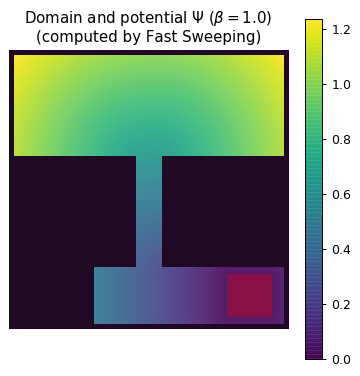

In [22]:
alphm = .9

fig = plt.figure()
im_ = plot_measure((1-mask) * potential_new_, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img)
plot_domain(exit_layer, alpha=.3)

plt.title("Domain and potential $\\Psi$ ($\\beta=%.1f$)\n(computed by Fast Sweeping)"
          % beta)
plt.colorbar(im_)
plt.axis('off');

## Computation

In [23]:
from scipy.stats import norm
from scipy.spatial import distance

In [24]:
# x-direction kernel
cost_mat1 = distance.cdist(xar[:, None],
                           xar[:, None])  # distance between 1st-coordinates

In [25]:
N_t = 16
tmax = 2.
dt = tmax / N_t  # timestep

sigma = 0.3
epsilon = sigma ** 2
print("Epsilon:", epsilon)
## New epsilon-kernel
K1_eps = norm.pdf(cost_mat1, scale=(sigma * dt ** .5))
K_eps_op = lambda x: np.dot(K1_eps @ x, K1_eps)

Epsilon: 0.09


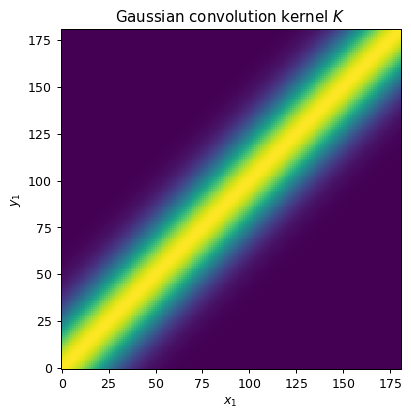

In [26]:
plt.imshow(K1_eps, origin='lower', interpolation='none')
plt.title("Gaussian convolution kernel $K$")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

The kernel is
$$
    \bfP_{i,j} = P_{h\epsilon}(x_j - x_i).
$$

Let's write the full Sinkhorn algorithm:

In [27]:
def _convolve_sinkhorn(a_s: List[np.ndarray], idx: int, verbose=False):
    """Perform partial convolution with the N marginals.
    idx: which index to leave out
    """
    n_marg = len(a_s)  # no. of marginals
    if verbose:
        print("Forward conv")
    A = 1
    # iterate convolution
    for j in range(idx):
        if verbose:
            print("marginal %d" % j)
        A = K_eps_op(A * a_s[j])
    
    if verbose:
        print("Backward conv")
    B = 1
    for j in range(n_marg - idx - 1):
        if verbose:
            print("marginal %d" % (n_marg-j-1))
        B = K_eps_op(B * a_s[n_marg-j-1])
    return A * B

In [28]:
rho_0.max()

0.000392156862745098

In [29]:
def prox_operator(mes, mask, congest_max):
    r"""Proximal operator"""
    return np.minimum(mes, congest_max) * (1-mask)

def multi_sinkhorn(a_s: List[np.ndarray], verbose=False):
    n_marg = len(a_s)  # no. of marginals
    conv = _convolve_sinkhorn(a_s, 0)
    a_s[0] = rho_0 / conv
    
    congest_max = 1.2 * rho_0.max()
    
    for k in range(1, n_marg-1):
        if verbose:
            print("Computing potential %d" % k)
        conv = _convolve_sinkhorn(a_s, k)
        numer = prox_operator(conv, mask, congest_max)
        a_s[k] = numer / conv
    
    conv = _convolve_sinkhorn(a_s, n_marg-1)
    a_s[n_marg - 1] = (1-mask) * np.exp(-potential_new_ / epsilon)

We get the marginals from
$$
    \rho_k^* = a_k^* \odot \mathbf{R}[(a^*_j)_{j\neq k}]
$$

In [30]:
a_s = [
    np.random.rand(nx, nx) for _ in range(N_t)
]

num_iters = 10
for _ in range(num_iters):
    multi_sinkhorn(a_s)

In [31]:
# Now compute the marginals from the potentials
marginals = [
    a * _convolve_sinkhorn(a_s, k) for k, a in enumerate(a_s)
]

In [32]:
for t, mu in enumerate(marginals):
    print("Time %d: max density %.3e" % (t, mu.max()))

Time 0: max density 3.922e-04
Time 1: max density 3.873e-04
Time 2: max density 3.192e-04
Time 3: max density 2.843e-04
Time 4: max density 2.629e-04
Time 5: max density 2.474e-04
Time 6: max density 2.345e-04
Time 7: max density 2.226e-04
Time 8: max density 2.111e-04
Time 9: max density 2.058e-04
Time 10: max density 2.243e-04
Time 11: max density 2.406e-04
Time 12: max density 2.570e-04
Time 13: max density 2.749e-04
Time 14: max density 3.140e-04
Time 15: max density 4.296e-04


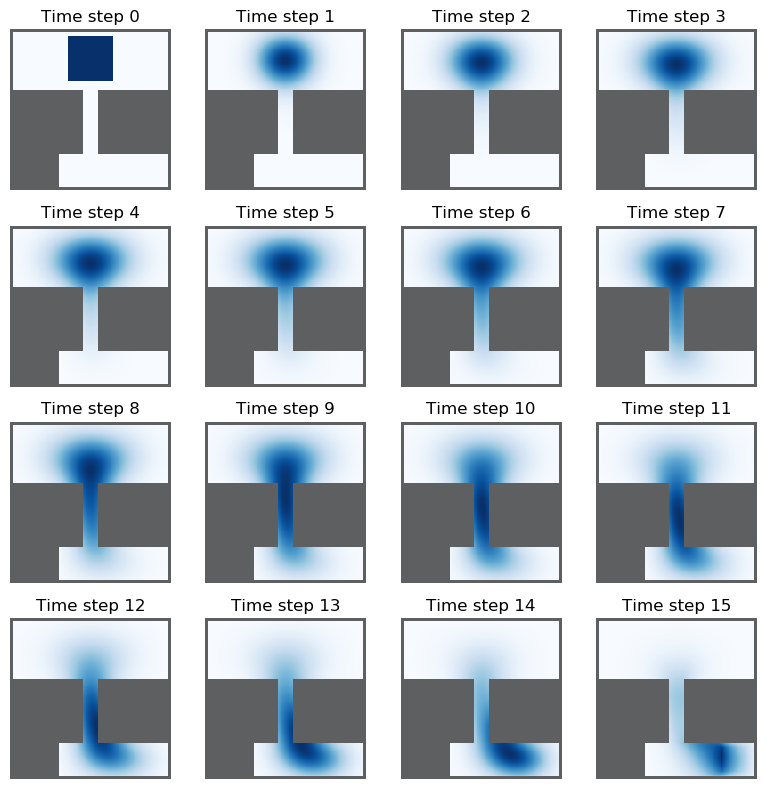

In [33]:
fig, axes = plt.subplots(len(a_s) // 4, 4, figsize=(8, 8), dpi=100)
axes = axes.ravel()

for i, mu in enumerate(marginals):
    ax = axes[i]
    plot_domain(domain_img, cax=ax)
    #ax.contourf(mu, levels=10, zorder=2)
    plot_measure(mu, cax=ax)
    ax.axis('off')
    ax.set_title("Time step %d" % (i))
fig.tight_layout();

In [34]:
fig.savefig(IMAGE_DIR+'multimarg_transport.png')